In [ ]:
from xgboost import XGBClassifier

In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from scipy.sparse import hstack

In [5]:
from prettytable import PrettyTable
pt = PrettyTable()

pt.field_names = ["Vectorizer", "Model", "Hyper-parameter", "AUC"]

#Reading data

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data = pd.read_csv('/content/gdrive/My Drive/Datasets/preprocessed_data.csv',nrows=100000)

In [ ]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [ ]:
data.shape

(100000, 9)

In [ ]:
import nltk 
from nltk.corpus import stopwords
nltk.download(('stopwords'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english')) 

#Train_test Split

In [ ]:
X = data.drop('project_is_approved',axis = 1)
Y = data['project_is_approved']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = .20,stratify = Y,random_state = 42)

In [ ]:
x_tr = pd.concat([x_train,y_train],axis = 1)
x_te = pd.concat([x_test,y_test],axis = 1)

In [ ]:
x_train.shape , y_train.shape

((80000, 8), (80000,))

#Response encoding 

In [ ]:
encoding_positive = {}
encoding_negative = {}

In [ ]:

def response_encoding(col):
  # col1 = {}
  for i in x_tr[col].unique():                              # for every unique value in a column
    
    # neg = i + '_0'
    # pos = i + '_1'
    count = x_tr[x_tr[col] == i].groupby('project_is_approved')[col].count()       # counting the frequency w.r.t project_approved 0/1
    # neg_value = len(df[(df['teacher_prefix'] == i) & (df['project_is_approved'] == 0)]) 
    # pos_value = len(df[(df['teacher_prefix'] == i) & (df['project_is_approved'] == 1)])
    # print(neg_value,pos_value)
    try:
      neg_value = count[0]/count.sum()                          # finding the prob score for negative class - 0
    except:
      neg_value = 0
    try:
      pos_value = count[1]/count.sum()                          # finding thre prob score of positive class - 1
    except:
      pos_value = 0
    
    encoding_negative[i] = neg_value                            # storing the pos and neg encoding vals in dictionary
    # col1[pos] = pos_value
    encoding_positive[i] = pos_value

In [ ]:
# teacher_prefix_encoding

In [ ]:

# count = x_tr[x_tr['project_subject_categories'] == 'history_civics_health_sports'].groupby('project_is_approved')['project_subject_categories'].count() 
# count

In [ ]:
response_encoding('teacher_prefix')

In [ ]:
response_encoding('project_grade_category')

In [ ]:
response_encoding('clean_categories')

In [ ]:
response_encoding('school_state')

In [ ]:
response_encoding('clean_subcategories')

In [ ]:
np.sort(df['school_state'].unique())

array(['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga',
       'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me',
       'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm',
       'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx',
       'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy'], dtype=object)

In [ ]:
encoding_negative

{'ak': 0.1510204081632653,
 'al': 0.14274447949526814,
 'appliedlearning': 0.17990026850786345,
 'appliedlearning health_sports': 0.17488789237668162,
 'appliedlearning history_civics': 0.18382352941176472,
 'appliedlearning literacy_language': 0.12776723592662872,
 'appliedlearning math_science': 0.19140625,
 'appliedlearning music_arts': 0.18604651162790697,
 'appliedlearning specialneeds': 0.19342359767891681,
 'appliedlearning warmth care_hunger': 0.25,
 'appliedsciences': 0.1888646288209607,
 'appliedsciences charactereducation': 0.18604651162790697,
 'appliedsciences civics_government': 0.16666666666666666,
 'appliedsciences college_careerprep': 0.19078947368421054,
 'appliedsciences communityservice': 0.125,
 'appliedsciences earlydevelopment': 0.19827586206896552,
 'appliedsciences economics': 0.3333333333333333,
 'appliedsciences environmentalscience': 0.20410958904109588,
 'appliedsciences esl': 0.0625,
 'appliedsciences extracurricular': 0.09278350515463918,
 'appliedscience

In [ ]:
encoding_positive

{'ak': 0.8489795918367347,
 'al': 0.8572555205047319,
 'appliedlearning': 0.8200997314921366,
 'appliedlearning health_sports': 0.8251121076233184,
 'appliedlearning history_civics': 0.8161764705882353,
 'appliedlearning literacy_language': 0.8722327640733712,
 'appliedlearning math_science': 0.80859375,
 'appliedlearning music_arts': 0.813953488372093,
 'appliedlearning specialneeds': 0.8065764023210832,
 'appliedlearning warmth care_hunger': 0.75,
 'appliedsciences': 0.8111353711790393,
 'appliedsciences charactereducation': 0.813953488372093,
 'appliedsciences civics_government': 0.8333333333333334,
 'appliedsciences college_careerprep': 0.8092105263157895,
 'appliedsciences communityservice': 0.875,
 'appliedsciences earlydevelopment': 0.8017241379310345,
 'appliedsciences economics': 0.6666666666666666,
 'appliedsciences environmentalscience': 0.7958904109589041,
 'appliedsciences esl': 0.9375,
 'appliedsciences extracurricular': 0.9072164948453608,
 'appliedsciences financiallite

#Transforming the values of categorical variables

https://www.w3schools.com/python/trypython.asp?filename=demo_ref_dictionary_get2

In [ ]:
category_column = ['teacher_prefix','school_state','project_grade_category','clean_categories','clean_subcategories']

In [ ]:
df1_train = x_tr[x_tr['project_is_approved'] == 0][category_column].applymap(lambda x: encoding_negative.get(x,0.5))

In [ ]:
df2_train = x_tr[x_tr['project_is_approved'] == 1][category_column].applymap(lambda x: encoding_positive.get(x,0.5))

In [ ]:
df3_train = pd.concat([df1_train,df2_train],axis = 0)

In [ ]:
df3_train.sort_index(inplace=True)

In [ ]:
# encoding_negative['grades_3_5']

0.14523139861927895

In [ ]:
df3_train.head()

,teacher_prefix,school_state,project_grade_category,clean_categories,clean_subcategories
0,0.854849,0.858008,0.848794,0.818663,0.812808
1,0.836945,0.837442,0.854769,0.811258,0.811258
2,0.854849,0.858008,0.848794,0.864509,0.880776
3,0.854849,0.835977,0.848794,0.820100,0.818033
4,0.854849,0.867262,0.854769,0.864509,0.880776


In [ ]:
# x_tr.sort_index().head(10)

###Test data encoding

In [ ]:
df1_test = x_te[x_te['project_is_approved'] == 0][category_column].applymap(lambda x: encoding_negative.get(x,0.5))

In [ ]:
df2_test = x_te[x_te['project_is_approved'] == 1][category_column].applymap(lambda x: encoding_positive.get(x,0.5))

In [ ]:
df3_test = pd.concat([df1_test,df2_test],axis = 0)

In [ ]:
df3_test.sort_index(inplace=True)

In [ ]:
# df3_test.head()

#Encoding Essay 

###Essay

In [ ]:
vectorizer = TfidfVectorizer(min_df=10,max_features=2500)

vectorizer.fit(x_train['essay'])
x_train_essay_tfidf = vectorizer.transform(x_train['essay'])
x_test_essay_tfidf = vectorizer.transform(x_test['essay'])

#Normalizing price

###Price

In [ ]:
normalizer = Normalizer()

In [ ]:

normalizer.fit(x_train['price'].values.reshape(1,-1))

x_train_price_norm = normalizer.transform(x_train['price'].values.reshape(1,-1))
# X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1))
x_test_price_norm = normalizer.transform(x_test['price'].values.reshape(1,-1))



print("After vectorizations")
print(x_train_price_norm[:50])
print(x_train_price_norm.shape, y_train.shape)

After vectorizations
[[0.00409842 0.00027308 0.00099101 ... 0.00039012 0.00359052 0.00060126]]
(1, 80000) (80000,)


###teacher_number_of_previously_posted_projects

In [ ]:
normalizer.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

x_train_teacher_ppp_norm = normalizer.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
# X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1))
x_test_teacher_ppp_norm = normalizer.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))



print("After vectorizations")
# print(X_train_teacher_ppp_norm[:50])
print(x_train_teacher_ppp_norm.shape, y_train.shape)
# print(X_cv_price_norm.shape, y_cv.shape)
# print(X_train_teacher_ppp_norm)
print(x_test_teacher_ppp_norm.shape, y_test.shape)

After vectorizations
(1, 80000) (80000,)
(1, 20000) (20000,)


#Sentiment Score

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
#train data

s1 = {'neg':[],'neu':[],'pos':[],'compound':[]}
for i in tqdm(x_train.index):
  ss = sid.polarity_scores(x_train.loc[i,'essay'])
  # ss1 = sid.polarity_scores(x_train['essay'])
  # print(ss.keys())
  s1['neg'].append(ss['neg'])
  s1['neu'].append(ss['neu'])
  s1['pos'].append(ss['pos'])
  s1['compound'].append(ss['compound'])
print(s1)
sentiment = pd.DataFrame(s1,index=x_train.index)

100%|██████████| 80000/80000 [02:52<00:00, 463.73it/s]


{'neg': [0.011, 0.016, 0.048, 0.091, 0.063, 0.034, 0.046, 0.032, 0.027, 0.079, 0.058, 0.058, 0.028, 0.018, 0.053, 0.0, 0.016, 0.076, 0.036, 0.092, 0.0, 0.048, 0.041, 0.03, 0.024, 0.015, 0.026, 0.0, 0.09, 0.013, 0.039, 0.057, 0.032, 0.0, 0.096, 0.07, 0.106, 0.084, 0.026, 0.044, 0.025, 0.03, 0.017, 0.011, 0.111, 0.058, 0.041, 0.085, 0.08, 0.091, 0.027, 0.109, 0.019, 0.0, 0.084, 0.055, 0.019, 0.01, 0.038, 0.031, 0.029, 0.04, 0.089, 0.042, 0.022, 0.037, 0.039, 0.017, 0.024, 0.025, 0.0, 0.0, 0.043, 0.072, 0.031, 0.046, 0.086, 0.082, 0.025, 0.108, 0.055, 0.025, 0.058, 0.016, 0.08, 0.06, 0.036, 0.062, 0.0, 0.04, 0.125, 0.045, 0.017, 0.038, 0.079, 0.053, 0.032, 0.094, 0.025, 0.056, 0.0, 0.075, 0.062, 0.008, 0.012, 0.086, 0.04, 0.013, 0.013, 0.0, 0.03, 0.033, 0.111, 0.01, 0.029, 0.036, 0.041, 0.066, 0.071, 0.084, 0.08, 0.086, 0.071, 0.01, 0.098, 0.013, 0.015, 0.05, 0.019, 0.032, 0.104, 0.056, 0.143, 0.064, 0.032, 0.083, 0.048, 0.036, 0.04, 0.014, 0.155, 0.013, 0.042, 0.09, 0.012, 0.016, 0.054, 

In [ ]:
#test data

s2 = {'neg':[],'neu':[],'pos':[],'compound':[]}
for i in tqdm(x_test.index):
  ss = sid.polarity_scores(x_test.loc[i,'essay'])
  # ss1 = sid.polarity_scores(x_train['essay'])
  # print(ss.keys())
  s2['neg'].append(ss['neg'])
  s2['neu'].append(ss['neu'])
  s2['pos'].append(ss['pos'])
  s2['compound'].append(ss['compound'])
print(s2)
sentiment_test = pd.DataFrame(s2,index=x_test.index)

100%|██████████| 20000/20000 [00:43<00:00, 459.54it/s]

{'neg': [0.126, 0.029, 0.035, 0.034, 0.045, 0.022, 0.035, 0.0, 0.038, 0.034, 0.01, 0.0, 0.028, 0.052, 0.0, 0.063, 0.046, 0.036, 0.088, 0.039, 0.041, 0.017, 0.056, 0.062, 0.034, 0.014, 0.04, 0.047, 0.057, 0.081, 0.011, 0.014, 0.008, 0.046, 0.06, 0.042, 0.038, 0.034, 0.0, 0.092, 0.069, 0.092, 0.038, 0.035, 0.013, 0.024, 0.082, 0.048, 0.021, 0.023, 0.009, 0.055, 0.017, 0.012, 0.206, 0.156, 0.092, 0.03, 0.041, 0.048, 0.16, 0.052, 0.0, 0.033, 0.049, 0.084, 0.0, 0.018, 0.049, 0.017, 0.025, 0.034, 0.051, 0.035, 0.026, 0.051, 0.089, 0.019, 0.019, 0.063, 0.075, 0.026, 0.03, 0.128, 0.039, 0.042, 0.037, 0.0, 0.06, 0.01, 0.044, 0.013, 0.019, 0.042, 0.0, 0.064, 0.042, 0.063, 0.017, 0.033, 0.041, 0.07, 0.051, 0.0, 0.045, 0.0, 0.073, 0.083, 0.052, 0.018, 0.027, 0.012, 0.056, 0.044, 0.114, 0.066, 0.0, 0.073, 0.046, 0.0, 0.046, 0.008, 0.071, 0.045, 0.03, 0.038, 0.053, 0.047, 0.0, 0.0, 0.032, 0.084, 0.04, 0.039, 0.102, 0.093, 0.015, 0.08, 0.055, 0.111, 0.045, 0.006, 0.044, 0.038, 0.044, 0.0, 0.038, 0.01

In [ ]:
sentiment.values

array([[0.011 , 0.506 , 0.484 , 0.998 ],
       [0.016 , 0.835 , 0.149 , 0.9432],
       [0.048 , 0.602 , 0.35  , 0.9931],
       ...,
       [0.051 , 0.807 , 0.141 , 0.8627],
       [0.034 , 0.655 , 0.311 , 0.9931],
       [0.065 , 0.741 , 0.194 , 0.968 ]])

#Final Dataset

In [ ]:
x_train_essay_tfidf.shape

(80000, 2500)

In [ ]:
x_tr_tfidf = hstack((df3_train.values,x_train_price_norm.T,x_train_teacher_ppp_norm.T,sentiment.values,x_train_essay_tfidf)).tocsr()
x_te_tfidf = hstack((df3_test.values,x_test_price_norm.T,x_test_teacher_ppp_norm.T,sentiment_test.values,x_test_essay_tfidf)).tocsr()

#XGBOOST MODEL

In [ ]:
model = XGBClassifier(random_state=42,n_jobs=-1)

In [ ]:
params = {'max_depth' : [3,4,5,6],'gamma':[0.1,1,0.01,10]}#,'alpha':[0.01,0.1,1,10,100],'eta':[0.01,0.05,0.1,0.5],

In [ ]:
clf = RandomizedSearchCV(model,param_distributions=params,n_jobs= -1, cv = 3 , return_train_score=True,random_state=10)

In [ ]:
# clf = GridSearchCV(model,param_grid=params,scoring='roc_auc',cv=3,return_train_score=True,n_jobs=-1)

In [ ]:
result = clf.fit(x_tr_tfidf,y_train)

In [ ]:
clf.best_params_

{'gamma': 0.01, 'max_depth': 5}

In [ ]:
clf.best_score_

0.8493625018279486

In [ ]:
scores = pd.DataFrame.from_dict(result.cv_results_)

In [ ]:
scores.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,160.545953,2.624806,2.132401,0.060622,4,1,"{'max_depth': 4, 'gamma': 1}",0.848802,0.849064,0.848834,0.848900,0.000117,8,0.849943,0.849962,0.850246,0.85005,0.000139
1,234.114589,1.459930,2.158817,0.012526,6,0.1,"{'max_depth': 6, 'gamma': 0.1}",0.849514,0.849289,0.849171,0.849325,0.000142,2,0.857237,0.855437,0.855927,0.85620,0.000760


In [ ]:
heat_test = scores.pivot('param_max_depth','param_gamma','mean_test_score')

In [ ]:
heat_train = scores.pivot('param_max_depth','param_gamma','mean_train_score')

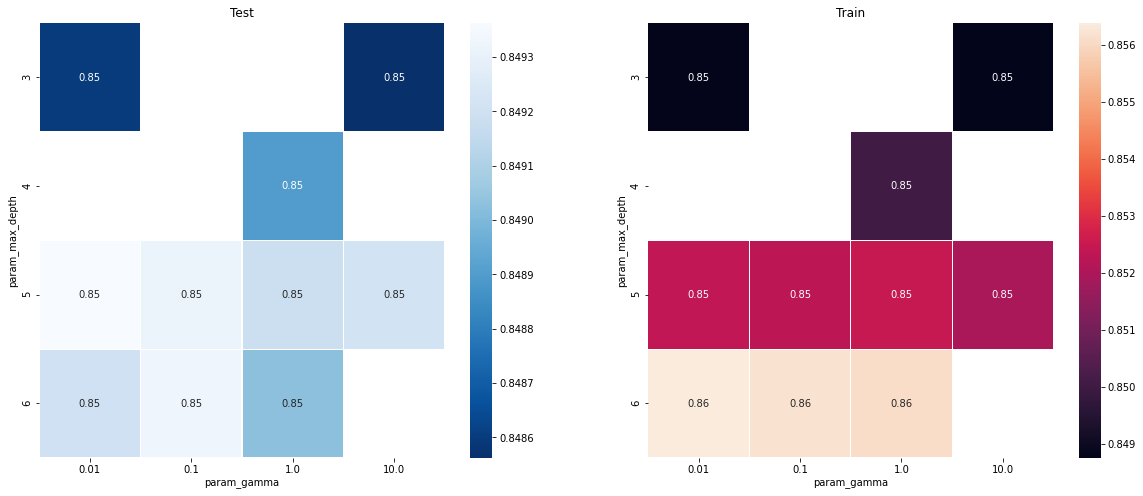

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('Test')
sns.heatmap(heat_test,annot=True,cmap='Blues_r',linewidths=0.1)
plt.subplot(1,2,2)
plt.title('Train')
sns.heatmap(heat_train,annot = True,linewidths=0.1)

Since it's random search CV not all combination parameters are tried in CV

In [ ]:
fin_model = XGBClassifier(max_depth=result.best_params_['max_depth'],alpha=result.best_params_['gamma'],random_state=10)

In [ ]:
fin_model.fit(x_tr_tfidf,y_train)

XGBClassifier(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred_tr = fin_model.predict(x_tr_tfidf)

In [ ]:
y_pred_te = fin_model.predict(x_te_tfidf)

###Prob scores for ROC-AUC curve

In [ ]:
y_pred_prob_tr = fin_model.predict_proba(x_tr_tfidf)

In [ ]:
y_pred_prob_te = fin_model.predict_proba(x_te_tfidf)

In [ ]:
x_tr_fpr,x_tr_tpr,x_tr_thresh = roc_curve(y_train,y_pred_prob_tr.flatten()[1::2])

In [ ]:
x_te_fpr,x_te_tpr,x_te_thresh = roc_curve(y_test,y_pred_prob_te.flatten()[1::2])

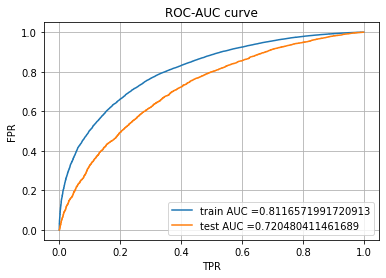

In [ ]:
plt.plot(x_tr_fpr, x_tr_tpr, label="train AUC ="+str(auc(x_tr_fpr, x_tr_tpr)))
plt.plot(x_te_fpr, x_te_tpr, label="test AUC ="+str(auc(x_te_fpr, x_te_tpr)))
plt.legend()
plt.xlabel('TPR')
plt.ylabel("FPR")
plt.title("ROC-AUC curve")
plt.grid()
plt.show()

In [ ]:
pt.add_row(['TFIDF','Decision Tree',f'{clf.best_params_}',str(auc(x_te_fpr, x_te_tpr))])

##Confusion matrix

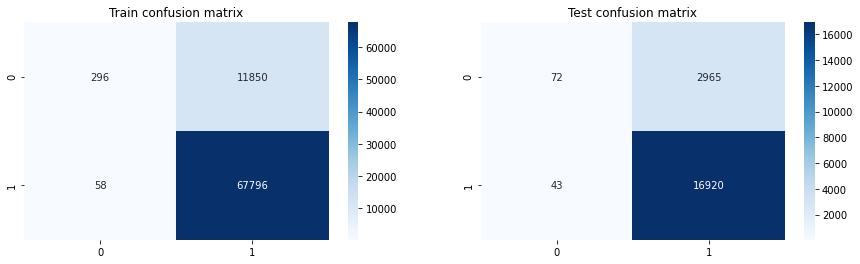

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# best_t = find_best_threshold(tr_thresholds_tfidf, train_fpr_tfidf, train_tpr_tfidf)
# print("Train confusion matrix")
# print(confusion_matrix(y_train, tr_pred_cm))
# print("Test confusion matrix")
# print(confusion_matrix(y_test,te_pred_cm))

plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title("Train confusion matrix")
sns.heatmap(confusion_matrix(y_train, y_pred_tr),annot=True,fmt="d",cmap='Blues')
plt.subplot(1,2,2)
plt.title("Test confusion matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_te),annot=True,fmt="d",cmap='Blues')
plt.show()

#TFIDF avg w2v

In [ ]:
with open('/content/gdrive/My Drive/Datasets/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(vectorizer.get_feature_names())

In [ ]:
# Train dataset

from tqdm import tqdm
preprocessed_essays = x_train['essay'].values
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|██████████| 80000/80000 [02:33<00:00, 521.10it/s]

80000
300


In [ ]:
# Test dataset

tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

100%|██████████| 20000/20000 [00:38<00:00, 518.96it/s]


In [ ]:
np.array(tfidf_w2v_vectors).shape

(80000, 300)

##Final dataset

In [ ]:
# x_h = np.concatenate((df3_train.values,np.array(tfidf_w2v_vectors)),axis=1)

In [ ]:
x_tr_tfidf_w2v = np.concatenate((df3_train.values,x_train_price_norm.T,x_train_teacher_ppp_norm.T,sentiment.values,np.array(tfidf_w2v_vectors)),axis = 1)
x_te_tfidf_w2v = np.concatenate((df3_test.values,x_test_price_norm.T,x_test_teacher_ppp_norm.T,sentiment_test.values,np.array(tfidf_w2v_vectors_test)), axis =1)

In [ ]:
x_tr_tfidf_w2v.shape

(80000, 311)

#XGBOOST MODEL (ESSAY TFIDF-W2V)

In [ ]:
model = XGBClassifier(random_state=42,n_jobs=-1)

In [ ]:
params = {'max_depth' : [3,4,5,6],'gamma':[0.1,1,0.01,10]}#,'alpha':[0.01,0.1,1,10,100],'eta':[0.01,0.05,0.1,0.5],

In [ ]:
clf = RandomizedSearchCV(model,param_distributions=params,n_jobs= -1, cv = 3 , return_train_score=True,random_state=10)

In [ ]:
result = clf.fit(x_tr_tfidf_w2v,y_train)

In [ ]:
clf.best_params_

{'gamma': 1, 'max_depth': 6}

In [ ]:
clf.best_score_

0.8489875022965873

In [ ]:
scores = pd.DataFrame.from_dict(result.cv_results_)

In [ ]:
scores.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,258.830935,2.839143,0.263127,0.003891,4,1,"{'max_depth': 4, 'gamma': 1}",0.848277,0.848539,0.848421,0.848413,0.000107,8,0.851443,0.851162,0.850977,0.851194,0.000192
1,389.352154,1.373014,0.346355,0.003852,6,0.1,"{'max_depth': 6, 'gamma': 0.1}",0.848239,0.849139,0.848496,0.848625,0.000379,6,0.867999,0.869780,0.868489,0.868756,0.000751


In [ ]:
heat_test = scores.pivot('param_max_depth','param_gamma','mean_test_score')

In [ ]:
heat_train = scores.pivot('param_max_depth','param_gamma','mean_train_score')

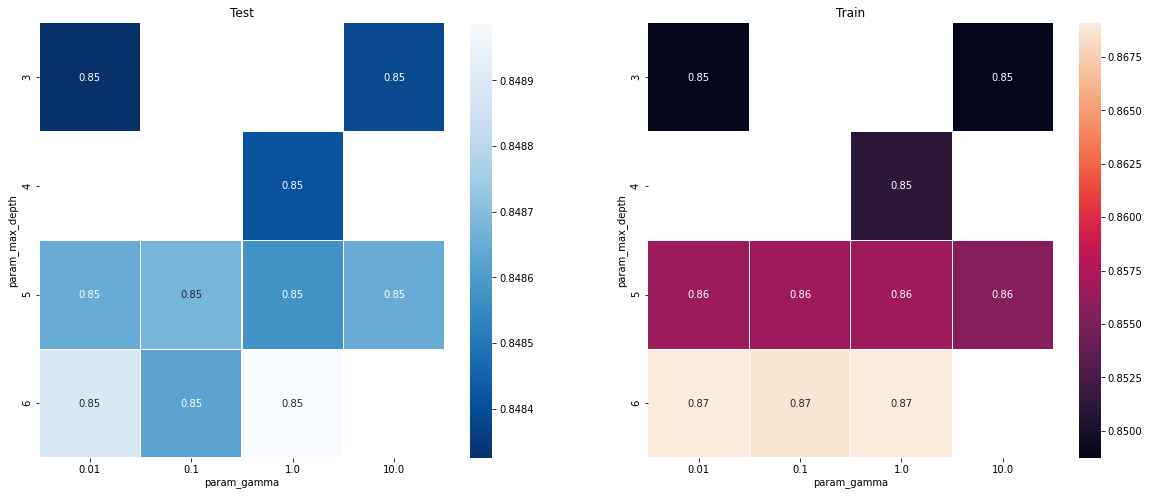

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('Test')
sns.heatmap(heat_test,annot=True,cmap='Blues_r',linewidths=0.1)
plt.subplot(1,2,2)
plt.title('Train')
sns.heatmap(heat_train,annot = True,linewidths=0.1)

In [ ]:
fin_model = XGBClassifier(max_depth=result.best_params_['max_depth'],alpha=result.best_params_['gamma'],random_state=10)

In [ ]:
fin_model.fit(x_tr_tfidf_w2v,y_train)

XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
x_pred = fin_model.predict(x_tr_tfidf_w2v)

In [ ]:
y_pred = fin_model.predict(x_te_tfidf_w2v)

##Prob scores for ROC-AUC curve

In [ ]:
x_pred_prob = fin_model.predict_proba(x_tr_tfidf_w2v)

In [ ]:
y_pred_prob = fin_model.predict_proba(x_te_tfidf_w2v)

In [ ]:
x_tr_fpr,x_tr_tpr,x_tr_thresh = roc_curve(y_train,x_pred_prob.flatten()[1::2])


In [ ]:
x_te_fpr,x_te_tpr,x_te_thresh = roc_curve(y_test,y_pred_prob.flatten()[1::2])

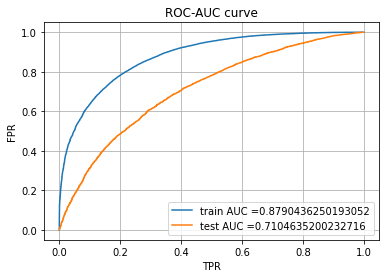

In [ ]:
plt.plot(x_tr_fpr, x_tr_tpr, label="train AUC ="+str(auc(x_tr_fpr, x_tr_tpr)))
plt.plot(x_te_fpr, x_te_tpr, label="test AUC ="+str(auc(x_te_fpr, x_te_tpr)))
plt.legend()
plt.xlabel('TPR')
plt.ylabel("FPR")
plt.title("ROC-AUC curve")
plt.grid()
plt.show()

It can be seen that, the model is slightly overfitting as the gap between train and test AUC scores are significant. Further more regularization can be done to reduce the overfitting

In [ ]:
pt.add_row(['TFIDF','Decision Tree',f'{clf.best_params_}',str(auc(x_te_fpr, x_te_tpr))])

##Confusion matrix

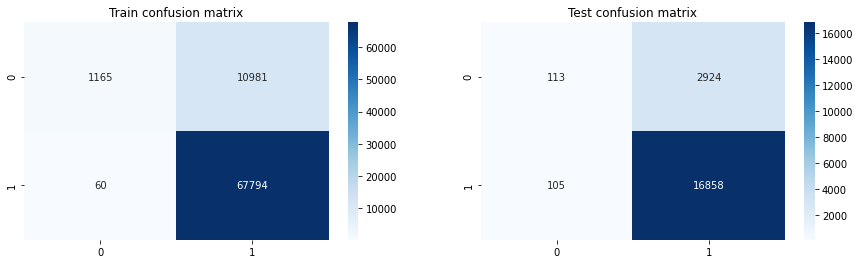

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.title("Train confusion matrix")
sns.heatmap(confusion_matrix(y_train, x_pred),annot=True,fmt="d",cmap='Blues')
plt.subplot(1,2,2)
plt.title("Test confusion matrix")
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt="d",cmap='Blues')
plt.show()

#Pretty table

In [8]:
print(pt)

+------------+---------+---------------------------------+--------------------+
| Vectorizer |  Model  |         Hyper-parameter         |        AUC         |
+------------+---------+---------------------------------+--------------------+
|   TFIDF    | XGBOOST | {'gamma': 0.01, 'max_depth': 5} | 0.720480411461689  |
| TFIDF-w2v  | XGBOOST |   {'gamma': 1, 'max_depth': 6}  | 0.7104635200232716 |
+------------+---------+---------------------------------+--------------------+
